## Sprint 深層学習スクラッチ 畳み込みニューラルネットワーク2

### 2.2次元の畳み込みニューラルネットワークスクラッチ

$$
2次元に対応した畳み込みニューラルネットワーク（CNN）のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。

プーリング層なども作成することで、CNNの基本形を完成させます。クラスの名前はScratch2dCNNClassifierとしてください。

#### データセットの用意
引き続きMNISTデータセットを使用します。2次元畳み込み層へは、28×28の状態で入力します。

今回は白黒画像ですからチャンネルは1つしかありませんが、チャンネル方向の軸は用意しておく必要があります。

(n_samples, n_channels, height, width)のNCHWまたは(n_samples, height, width, n_channels)のNHWCどちらかの形にしてください。
$$


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

#### 【問題1】2次元畳み込み層の作成
1次元畳み込み層のクラスConv1dを発展させ、2次元畳み込み層のクラスConv2dを作成してください。

フォワードプロパゲーションの数式は以下のようになります。  

$$
a_{i,j,m} = \sum_{k=0}^{K-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1}x_{(i+s),(j+t),k}w_{s,t,k,m}+b_{m}
$$

$$
a
i
,
j
,
m
 : 出力される配列のi行j列、mチャンネルの値  

i
 : 配列の行方向のインデックス  

j
 : 配列の列方向のインデックス  

m
 : 出力チャンネルのインデックス  

K
 : 入力チャンネル数  

F
h
,
F
w
 : 高さ方向（h）と幅方向（w）のフィルタのサイズ  

x
(
i
+
s
)
,
(
j
+
t
)
,
k
 : 入力の配列の(i+s)行(j+t)列、kチャンネルの値  

w
s
,
t
,
k
,
m
 : 重みの配列のs行t列目。kチャンネルの入力に対して、mチャンネルへ出力する重み  

b
m
 : mチャンネルへの出力のバイアス項  
 $$

全てスカラーです。  

次に更新式です。1次元畳み込み層や全結合層と同じ形です。  
$$
w_{s,t,k,m}^{\prime} = w_{s,t,k,m} - \alpha \frac{\partial L}{\partial w_{s,t,k,m}} \\
b_{m}^{\prime} = b_{m} - \alpha \frac{\partial L}{\partial b_{m}}
$$
$$
α
 : 学習率  

∂
L
∂
w
s
,
t
,
k
,
m
 : 
w
s
,
t
,
k
,
m
 に関する損失   
L
 の勾配  

∂
L
∂
b
m
 : 
b
m
 に関する損失   
L
 の勾配  

勾配   
∂
L
∂
w
s
,
t
,
k
,
m
 や 
∂
L
∂
b
m
 を求めるためのバックプロパゲーションの数式が以下である。
 $$  
$$
 \frac{\partial L}{\partial w_{s,t,k,m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1} \frac{\partial L}{\partial a_{i,j,m}}x_{(i+s)(j+t),k}\\
\frac{\partial L}{\partial b_{m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1}\frac{\partial L}{\partial a_{i,j,m}}

$$

$$
∂
L
∂
a
i
 : 勾配の配列のi行j列、mチャンネルの値  

N
o
u
t
,
h
,
N
o
u
t
,
w
 : 高さ方向（h）と幅方向（w）の出力のサイズ  
$$
前の層に流す誤差の数式は以下です。  
$$
\frac{\partial L}{\partial x_{i,j,k}} = \sum_{m=0}^{M-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1} \frac{\partial L}{\partial a_{(i-s),(j-t),m}}w_{s,t,k,m}
$$

$$
∂
L
∂
x
i
,
j
,
k
 : 前の層に流す誤差の配列のi列j行、kチャンネルの値   
 

M
 : 出力チャンネル数  

ただし、 
i
−
s
<
0
 または 
i
−
s
>
N
o
u
t
,
h
−
1
 または 
j
−
t
<
0
 または 
j
−
t
>
N
o
u
t
,
w
−
1
 のとき 
∂
L
∂
a
(
i
−
s
)
,
(
j
−
t
)
,
m
=
0
 です。  

 $$

In [2]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist

In [3]:
(X_train,y_train),(X_test,y_test) = mnist.load_data()
#前処理
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255


In [4]:
#NCHW
X_train = X_train[:,np.newaxis,:,:]
X_test = X_test[:,np.newaxis,:,:]

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [6]:
X_train.shape

(48000, 1, 28, 28)

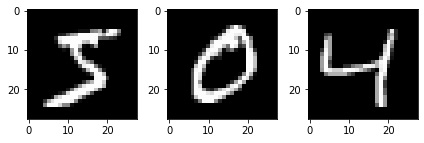

In [7]:
# 取得する枚数を指定
B = 3

# データセット取得
(x_train, _), (_, _) = mnist.load_data()
x_train = x_train[:B]

# 表示してみる
fig, ax = plt.subplots(1, B)
for i, x in enumerate(x_train):
    ax[i].imshow(x, cmap="gray")
fig.tight_layout()
plt.savefig("mnist_data.png")
plt.show()

In [8]:
# a_ijm = np.zeros((i,j,m))
# for K in range(k):
#     for Fh in range(Fh):
#         for Fw in range(Fw):
#             a[i, j, m] = x[K,i: i + Fh, j: j + Fw] * w[Fh, Fw, K , m] + b[m]

In [9]:
a = np.arange(1, 9).reshape(2, 2, 2)
A = np.array([['a', 'b', 'c', 'd']], dtype=object).reshape(2, 2)
a,A

(array([[[1, 2],
         [3, 4]],
 
        [[5, 6],
         [7, 8]]]),
 array([['a', 'b'],
        ['c', 'd']], dtype=object))

In [10]:
# class Conv2d1:
#     def __init__(self, m, k, kh, kw, act):
#         self.W = np.random.nomal(0, np.sqrt(2/ (m* kh* kw)), (m, k, kh, kw))
#         self.kh = kh
#         self.kw = kw
#         self.activation= act
#     def forward(self, X):
#         return self.activation.activate(self._forward(X))

#     def backward(self, delta, shape):
#         n_batch, k, h, w = delta.shape
#         delta_patch = np.tensordot(delta.reshape(s_batch, k, h * w), self.W, (1, 0))
#         return self._patch2i(delta_patch, h, w, shape)

#     def update(self, delta, epsilon):
#         n_batch, k, h, w = delta.shape
#         self.weight -= epsilon * self._grad(delta, s_batch, k, h, w)

#     def _forward(self, X):
#         n_batch, k, xh, xw = X.shape
#         m = self.W.shape[0]
#         oh, ow = xh - self.kh / 2 * 2, xw - self.kw / 2 * 2
#         self._patch = self._im2p(X, n_batch, k, oh, ow)
#         A = np.tensordot(self.patch, self.weight, ((2,3,4), (1,2,3))).swapaxes(1,2).reshape(n_batch, m, oh, ow)
#         return A

#     def _im2p(self, X, n_batch, k, oh, ow):
#         patch = np.zeros((n_batch, oh * ow, k, self.kh, self.kw))
#         for h in range(oh):
#             for w in range(ow):
#                 patch[:, h * ow + w, :, :, :] = X[:, :, h: h + self.kh, w: w+self.kw]
#         return patch
    
#     def _backward(self, delta, shape):
#         n_batch, k, h, w = delta.shape
#         delta_patch = np.tensordot(delta.shape(n_batch, k, h * w), self.W, (1, 0))
#         dX = self._patch2i(delta_ptch, h, w, shape)
#         return dX

#     def _patch2i(self, patch, h, w, shape):
#         im = np.zeros(shape)
#         for j in range(h):
#             for i in range(w):
#                 im[:, :, j : j+self.kh, i:i+self.kw] += patch[:, j * w + i]
#                 return im

#     def _grad(self, delta, n_batch, k, h, w):
#         return np.tensordot(delta.reshape(n_batch, k, h * w), self._patch, ((0, 2), (0, 1))) / n_batch

#### 【問題2】小さな配列での2次元畳み込み層の実験
次に示す小さな配列でフォワードプロパゲーションとバックプロパゲーションが正しく行えているか確認してください。

入力x、重みwを次のようにします。

In [335]:
#CNN2 のフォワードを流す時の入力データ
#(2,3,3)
#(1,1,4,4)
x = np.array([
[
[
[ 1, 2, 3, 4],
[ 5, 6, 7, 8],
[ 9, 10, 11, 12],
[13, 14, 15, 16]
],
],
])
w = np.array([
[
[ 0., 0., 0.],
[ 0., 1., 0.],
[ 0., -1., 0.],
],
[
[ 0., 0., 0.],
[ 0., -1., 1.],
[ 0., 0., 0.]
]
])
#(?,1,2,2,)

In [296]:
x,x.shape,w,w.shape

(array([[[[ 1,  2,  3,  4],
          [ 5,  6,  7,  8],
          [ 9, 10, 11, 12],
          [13, 14, 15, 16]]]]),
 (1, 1, 4, 4),
 array([[[ 0.,  0.,  0.],
         [ 0.,  1.,  0.],
         [ 0., -1.,  0.]],
 
        [[ 0.,  0.,  0.],
         [ 0., -1.,  1.],
         [ 0.,  0.,  0.]]]),
 (2, 3, 3))

In [13]:
x

array([[[[ 1,  2,  3,  4],
         [ 5,  6,  7,  8],
         [ 9, 10, 11, 12],
         [13, 14, 15, 16]]]])

In [133]:
w.shape

(2, 3, 3)

In [14]:
forward_output = np.array([
[
[-4,-4],
[-4,-4],
],
[
[1,1],
[1,1],
]
])

フォワードプロパゲーションをすると出力は次のようになります。


In [83]:
forward_output

array([[[-4, -4],
        [-4, -4]],

       [[ 1,  1],
        [ 1,  1]]])

In [82]:
#im2colを考える

    # Params
    # ---------
    # input_data :data_num, chanel, hight, haba, 
    # filter_h : filter no takasa
    # filter_w : filter no haba
    # stride
    # pad : padding

    # returns
    # --------
    # col : 2dim hairetu


In [154]:
#ストライド　パディングなし
def im2col3(input_data,filter_h,filter_w):
    N, C, H, W = input_data.shape
    O_h = H - filter_h + 1
    print(O_h)
    O_w = W - filter_w +1
    print(O_w)
    cols = np.empty((N, C, filter_h, filter_w, O_h, O_w))
    for h in range(filter_h):
        for w in range(filter_w):
            cols[:, :, h, w, :, :] = input_data[:, :, h : h+O_h, w : w+O_w]
            
    #N C Fh Fw Oh Ow -> C Fh Fw N Oh Ow
    return cols.transpose(1,2,3,0,4,5).reshape(C*filter_h*filter_w, N*O_h*O_w)

In [156]:
F_n,F_c,F_h,F_w = w[:,np.newaxis,:,:].shape
print(F_h,F_w)
a = im2col3(x,F_h,F_w)
a,a.shape

3 3
2
2


(array([[ 1.,  2.,  5.,  6.],
        [ 2.,  3.,  6.,  7.],
        [ 3.,  4.,  7.,  8.],
        [ 5.,  6.,  9., 10.],
        [ 6.,  7., 10., 11.],
        [ 7.,  8., 11., 12.],
        [ 9., 10., 13., 14.],
        [10., 11., 14., 15.],
        [11., 12., 15., 16.]]),
 (9, 4))

In [155]:
b = im2col3(w[:,np.newaxis,:,:],F_h,F_w)
b,b.shape

1
1


(array([[ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 1., -1.],
        [ 0.,  1.],
        [ 0.,  0.],
        [-1.,  0.],
        [ 0.,  0.]]),
 (9, 2))

In [20]:
b.T

array([[ 0.,  0.,  0.,  0.,  1.,  0.,  0., -1.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  1.,  0.,  0.,  0.]])

In [21]:
#bになる前
w

array([[[ 0.,  0.,  0.],
        [ 0.,  1.,  0.],
        [ 0., -1.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0., -1.,  1.],
        [ 0.,  0.,  0.]]])

アウトプットのshape： O_h=2,O_w=2  
x の枚数（バッチ数）：N=2  
A = shape(N, O_h, O_w)　 の形状に変換


In [126]:
c = b.T @ a
c = c.reshape(2,2,2)
c,c.shape

(array([[[-4., -4.],
         [-4., -4.]],
 
        [[ 1.,  1.],
         [ 1.,  1.]]]),
 (2, 2, 2))

In [110]:
#ストライド　パディングあり
def im2col4(input_data,filter_h,filter_w):
    N, C, H, W = input_data.shape
    O_h = H - filter_h + 1
    print(O_h)
    O_w = W - filter_w +1
    print(O_w)
    cols = np.empty((N, C, filter_h, filter_w, O_h, O_w))
    for h in range(filter_h):
        for w in range(filter_w):
            cols[:, :, h, w, :, :] = input_data[:, :, h : h+O_h, w : w+O_w]
            
    #N C Fh Fw Oh Ow -> C Fh Fw N Oh Ow
    return cols.transpose(1,2,3,0,4,5).reshape(C*filter_h*filter_w, N*O_h*O_w)

次にバックプロパゲーションを考えます。誤差は次のようであったとします。

In [25]:
delta = np.array([
[
[-4,-4],
[10,11],
],
[
[1,-7],
[1,-11],
]
])

In [26]:
delta.shape

(2, 2, 2)

In [27]:
grad = delta.reshape(-1,2)
grad,grad.shape

(array([[ -4,  -4],
        [ 10,  11],
        [  1,  -7],
        [  1, -11]]),
 (4, 2))

In [28]:
pra = np.pad(grad,(1,))
pra

array([[  0,   0,   0,   0],
       [  0,  -4,  -4,   0],
       [  0,  10,  11,   0],
       [  0,   1,  -7,   0],
       [  0,   1, -11,   0],
       [  0,   0,   0,   0]])

In [369]:
pra.shape

(6, 4)

In [371]:
cc = c.reshape(-1,2)
dgra = pra@cc
dgra

array([[  0.,   0.],
       [ 12.,  12.],
       [-29., -29.],
       [-11., -11.],
       [-15., -15.],
       [  0.,   0.]])

In [325]:
b.shape

(9, 2)

In [339]:
dx =grad@b.T
dx,dx.shape

(array([[  0.,   0.,   0.,   0.,   0.,  -4.,   0.,   4.,   0.],
        [  0.,   0.,   0.,   0.,  -1.,  11.,   0., -10.,   0.],
        [  0.,   0.,   0.,   0.,   8.,  -7.,   0.,  -1.,   0.],
        [  0.,   0.,   0.,   0.,  12., -11.,   0.,  -1.,   0.]]),
 (4, 9))

In [395]:
O_shape = 2,2,2

In [294]:
x.shape

(1, 1, 4, 4)

In [393]:
def col2im(cols, I_shape, O_shape):
    N,I_h, I_w = I_shape
    M,O_h, O_w = O_shape
    filter_h = I_h - O_h +1
    filter_w = I_w - O_w +1
    print(filter_h)
    print(filter_w)
    print(O_h)
    print(O_w)
    cols = cols.reshape(filter_h, filter_w,N, O_h, O_w).transpose(2,0,1,3,4)
    images = np.empty((N,I_h, I_w))

    for h in range(3):
        h_lim = h + O_h
        for w in range(3):
            w_lim = w + O_w
            images[:, :, h: h_lim, w: w_lim] += cols[:,:,h, w, :, :]
    return images

B, Oh, Ow  
2, 2, 2 とする  
B, M,Oh, Ow  にし  
B, Oh, Ow, Mとする  


In [340]:
col2_dx = col2im(dx.T,x.shape,O_shape)
col2_dx,col2_dx.shape

3
3
2
2


(array([[[[  0.,   0.,   0.,   0.],
          [  0.,   0.,  -5.,  11.],
          [  0.,  12.,  -5., -11.],
          [  0.,  -1.,  -1.,   0.]]]]),
 (1, 1, 4, 4))

バックプロパゲーションをすると次のような値になります。パディングがある場合の答えになります。

In [270]:
back_output = np.array([
[-5,4],
[13,27],
])

In [271]:
back_output.shape

(2, 2)

### 【問題3】2次元畳み込み後の出力サイズ


畳み込みを行うと特徴マップのサイズが変化します。どのように変化するかは以下の数式から求められます。この計算を行う関数を作成してください。
$$
N_{h,out} =  \frac{N_{h,in}+2P_{h}-F_{h}}{S_{h}} + 1\\
N_{w,out} =  \frac{N_{w,in}+2P_{w}-F_{w}}{S_{w}} + 1
$$

N
o
u
t
 : 出力のサイズ（特徴量の数） 

N
i
n  
 : 入力のサイズ（特徴量の数）

P
 : ある方向へのパディングの数    

F
 : フィルタのサイズ  

S
 : ストライドのサイズ  

h
 が高さ方向、 
w
 が幅方向である


In [8]:
def output(X,w,S=1,P=0):
    S=S
    P=P
    H,W = X.shape
    F_h,F_w = w.shape
    O_h = (H + 2*P - F_h)/ S + 1
    O_w = (W + 2*P - F_w)/ S + 1
    return O_h,O_w

#### 【問題3】最大プーリング層の作成
最大プーリング層のクラスMaxPool2Dを作成してください。プーリング層は数式で表さない方が分かりやすい部分もありますが、数式で表すとフォワードプロパゲーションは以下のようになります。
$$
a_{i,j,k} = \max_{(p,q)\in P_{i,j}}x_{p,q,k}
$$


P
i
,
j
 : i行j列への出力する場合の入力配列のインデックスの集合。  
S
h
×
S
w
 の範囲内の行（p）と列（q） 

S
h
,
S
w
 : 高さ方向（h）と幅方向（w）のストライドのサイズ  

(
p
,
q
)
∈
P
i
,
j
 : 
P
i
,
j
 に含まれる行（p）と列（q）のインデックス  

a
i
,
j
,
m
 : 出力される配列のi行j列、kチャンネルの値  

x
p
,
q
,
k
 : 入力の配列のp行q列、kチャンネルの値  

ある範囲の中でチャンネル方向の軸は残したまま最大値を計算することになります。   

バックプロパゲーションのためには、フォワードプロパゲーションのときの最大値のインデックス   
(
p
,
q
)
 を保持しておく必要があります。  
 フォワード時に最大値を持っていた箇所にそのままの誤差を流し、そこ以外には0を入れるためです。  


In [8]:
class MaxPool2D():
    def __init__(self,conv):
        self.pool = 2
        self.max_idx = None
        self.conv = conv

    def forward(self,X):
        # print(self.conv.F_shape)
        # print("poolxshape",X.shape)
        N,C,H,W = X.shape
        self.O_h = int(1 + (H - self.pool))
        self.O_w = int(1 + (W - self.pool))
        self.O_shape =N,C,self.O_h,self.O_w
        # print(self.O_h)
        # print("N",N)
        # print("C",C)
        self.X, _,self.pad_satate = self.conv.im2col(X, self.pool,self.pool)
        # print(self.X.shape)
        self.X = self.X.reshape(-1, self.pool*self.pool)
        self.max_idx = np.argmax(self.X, axis=1)
        self.y =  self.max_idx.reshape(N,self.O_h,self.O_w,C).transpose(0,3,1,2)

        return self.y

    def backward(self, grad,I_shape=None):
        N = grad.shape[0]
        # print("grad.shape",grad.shape)
        # print("I_shape",I_shape.shape)
        _,C,H,W = I_shape.shape
        I_shape = N,*I_shape.shape
        # _,_,O_h,O_w = self.O_shape
        # print("O_shape",self.O_shape)
        grad = grad.transpose(0,2,3,1).reshape(-1,1)
        # print("grad",grad.size)
        self.dX = np.empty((grad.size, self.pool*self.pool))
        # print("maxidx",self.max_idx.shape)
        self.dX[:, self.max_idx] = grad
        # print("Zshape",I_shape)
        # print("dX",self.dX.shape)
        # print("N",N)
        # print("C",C)

        self.dX = self.dX.reshape(N*self.O_h*self.O_w,C*self.pool*self.pool).T
        # print("dX",self.dX.shape)
        self.dX = self.conv.col2im(self.dX, I_shape, self.O_shape,1)

        return self.dX


#### 【問題4】（アドバンス課題）平均プーリングの作成
平均プーリング層のクラスAveragePool2Dを作成してください。

範囲内の最大値ではなく、平均値を出力とするプーリング層です。

画像認識関係では最大プーリング層が一般的で、平均プーリングはあまり使われません。


#### 【問題5】平滑化
平滑化するためのFlattenクラスを作成してください。

フォワードのときはチャンネル、高さ、幅の3次元を1次元にreshapeします。その値は記録しておき、バックワードのときに再びreshapeによって形を戻します。

この平滑化のクラスを挟むことで出力前の全結合層に適した配列を作ることができます。


In [9]:
class Flatten():
    def __init__(self):
        self.X_shape = None
    def forward(self,X):
        # print("flatxshape",X.shape)
        x1d = X.reshape(X.shape[0],-1)
        self.X_shape = X.shape
        # print("x1d",x1d.shape)
        return x1d
    def backward(self,X):
        X = X.reshape(self.X_shape)
        return X

### 3.検証


#### 【問題6】学習と推定
作成したConv2dを使用してMNISTを学習・推定し、Accuracyを計算してください。

精度は低くともまずは動くことを目指してください。

In [10]:
class Conv2d:
    def __init__(self,B, f_num, f_h,f_w, initializer,optimizer,stride,I_shape,ch):
        self.optimizer = optimizer

        self.B = initializer.B(f_num)
        self.dW = None
        self.dB = None
        self.idx =None
        self.dX = None
        self.X = None
        self.A = None
        self.F_shape = f_num,1,f_h,f_w
        self.W = initializer.W(f_num=f_num,f_h=f_h,f_w=f_w,ch=ch)
        self.I_shape = I_shape
        #print(f_h)
        self.stride = stride
        _,self.O_shape,self.pad_state = self.im2col(np.zeros((self.I_shape)),f_h,f_w)

    def output(self,H,W,f_h,f_w,S=1,P=0):
        S=S
        P=P
        O_h = int((H + 2*P - f_h)// S + 1)
        O_w = int((W + 2*P - f_w)// S + 1)
        return O_h,O_w

    #パディングあり
    def im2col(self,images,filter_h,filter_w,S=1):
        pad = 0
        #print("image",images.shape)
        N, C, H, W = images.shape
        #print(filter_h)
        O_h,O_w = self.output(H,W,filter_h,filter_w)
        #print(O_h)
        cols = np.empty((N, C, filter_h, filter_w, O_h, O_w))
        images = np.pad(images, [(0, 0), (0, 0), (pad, pad), (pad, pad)], "constant")
        # print(S)
        for h in range(filter_h):
            h_lim = h + O_h*S
            for w in range(filter_w):
                w_lim = w + O_w * S
                cols[:, :, h, w, :, :] = images[:, :, h : h_lim:S, w : w_lim:S]

        ret_list = []     
        #N C Fh Fw Oh Ow -> C Fh Fw N Oh Ow
        ret_list.append(cols.transpose(1,2,3,0,4,5).reshape(C*filter_h*filter_w, N*O_h*O_w))
        ret_list.append((O_h,O_w))
        ret_list.append((0,0))

        return ret_list

    def col2im(self,cols, I_shape, O_shape,stride):
        # print("cols",cols.shape)
        # print("I_shape",I_shape)
        N,_,C,I_h,I_w = I_shape
        # print("I_shape",I_shape)
        # print("O.shaoe",O_shape)
        _,O_c,O_h,O_w = O_shape
        filter_h = int(I_h - O_h+1)
        filter_w = int(I_w - O_w +1)
        
        # print("f_h",filter_h)
        cols = cols.reshape(N,C,filter_h, filter_w,O_h,O_w)
        images = np.empty((N,C,I_h, I_w))
        for h in range(filter_h):
            h_lim = h + O_h*stride
            for w in range(filter_w):
                w_lim = w + O_w*stride
                images[:,:,h: h_lim:stride, w: w_lim:stride] += cols[:,:,h, w, :, :]
        return images

    def forward(self, X):
        # print("Xshape",X.shape)
        N,C,H,W = X.shape
        # print("Xshape",X.shape)
        M,_,F_h,F_w = self.F_shape
        O_h,O_w = self.output(H,W,F_h,F_w)
        self.O_shape = self.output(H,W,F_h,F_w)
        self.O_shape = C,*self.O_shape
        self.X,_,self.pad_state = self.im2col(X,F_h,F_w,S=self.stride)
        # print("self.X",self.X.shape)
        if self.W.ndim == 4:
            self.W,_,_, = self.im2col(self.W,F_h,F_w,S=self.stride)
        # self.W = self.W.reshape(M,-1)

        # print("X",self.X.shape)
        # print("W",self.W.shape)
        # print(self.B.shape)
        self.u = self.W.T @ self.X + self.B
        #print(self.u.shape)
        #print(B)
        #print(O_h)
        #print(O_w)
        A = self.u.reshape(M,N,O_h,O_w).transpose(1,0,2
        ,3)
        # print("A",A.shape)
        return A

    def backward(self, dA,A):
        # print("dA",dA.shape)
        N,C,H,W  = dA.shape
        I_shape = N,*A.shape
        # print("A",A.shape)
        O_shape = dA.shape
        # print("Ishape",I_shape)
        # O_shape = C,1,O_h,O_w
        # print("X.T",self.X.shape)

        dA = dA.transpose(1,0,2,3).reshape(C,-1)
        self.dW = dA @ self.X.T
        self.dB = np.sum(dA, axis=1).reshape(C,1)
        # print("dA",dA.shape)
        # print("self.W",self.W.shape)
        dX = self.W @ dA
        dX = self.col2im(dX,I_shape,O_shape,stride=self.stride)
        # print("dX",dX.shape)
        
        
        # 更新
        self = self.optimizer.update(self)
        return dX

In [11]:
class FC:
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        self.dW = None
        self.dB = None
        pass
    def forward(self, X):
        self.X = X.copy()
        # print('X',X.shape)
        # print('W',self.W.shape)
        A= X @ self.W
        A = A + self.B.flatten()
        return  A

    def backward(self, dA):
        self.dB = np.sum(dA,axis=0) 
        self.dW = self.X.T @ dA
        dZ = dA @ self.W.T #次の層で使う
        # 更新
        self = self.optimizer.update(self)
        return dZ

In [12]:
class ReLU:
    def __init__(self):
        self.A = None
    def forward(self, X):
        self.A = np.copy(X)
        return np.maximum(0,X)
    def backward(self, X):
        return np.where(X>0,1,0)

In [13]:
class ReLU2:
    def forward(self, X):
        self.A = X
        return np.clip(X, 0, None)
    
    def backward(self, dZ):
        return dZ * np.clip(np.sign(self.A), 0, None)

In [14]:
#softmax関数
class Softmax:
    def __init__(self):
        self.b = None
    def forward(self,x):
        self.b = np.exp(x-np.max(x))/np.sum(np.exp(x-np.max(x)), axis =1, keepdims =True)
        return self.b
    def backward(self,t):
        self.batch = t.shape[0]
        loss = -1/self.batch * np.sum(np.sum(t*np.log(self.b),axis=0))
        dx = (self.b - t) /self.batch
        return dx, loss

In [15]:
#ハイパボリックタンジェント
class Tanh():
    def __init__(self):
        self.A = None
    def forward(self,X):
        self.A = np.tanh(X)
        return self.A
    def backward(self,X):
        return X * (1 - (np.tanh(self.A))**2)

In [16]:
from sklearn.metrics import accuracy_score
class GetMiniBatch:
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [17]:
class HeInitializer:
    def __init__(self):
        pass
    def W(self, n_nodes1=None, n_nodes2=None,f_num=None,f_h=None,f_w=None,ch=None):
        if f_num is not None:
            W = np.random.randn(f_num,ch,f_h,f_w)* np.sqrt(2/f_num)
            # print("W",W.shape)
        else:
            W = np.random.randn(n_nodes1,n_nodes2) * np.sqrt(2/n_nodes1)
        return W
    def B(self, n_nodes2):
        B = np.random.randn(n_nodes2,1)     
        return B

In [18]:
class SGD:
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        #print("dB",layer.dB.shape)
        #print("B",layer.B.shape)
        if isinstance(layer.dB[0], list) :
            layer.B -= self.lr * layer.dB
        else:
            layer.B -= self.lr * layer.dB.reshape(-1,1)
        #print("dW",layer.dW.shape)
        #print("W",layer.W.shape)
        if layer.W.shape == layer.dW.shape:
            layer.W -= self.lr * layer.dW
        else:
            layer.W -= self.lr * layer.dW.T
        return 

In [34]:
class Scratchch2dCNNNeuralNetrowkClassifier():
    def __init__(self,lr=0.01,sigma=0.01,n_node1=200,n_node2=100,n_output=10,verbose=True,epoch=5,batch_size=10,activation="tanh",initial="he",optimizer="sgd",f_num=10,f_h=16,f_w=16,stride=1):
        self.lr = lr
        self.sigma = sigma
        self.n_nodes1 = n_node1
        self.n_nodes2 = n_node2
        self.n_output = n_output
        self.epoch = epoch
        self.verbose = verbose
        self.batch = batch_size
        self.activation = activation
        self.initial = initial
        self.optimizer = optimizer
        self.f_num = f_num
        self.f_h = f_h
        self.f_w = f_w
        self.stride = stride

    def fit(self,X,y,X_val=None,y_val=None):
        get_mini_batch = GetMiniBatch(X, y, self.batch)
        #val
        if X_val is not None:      
            test_mini_batch = GetMiniBatch(X_val, y_val) 

        self.B = self.batch
        N,C,I_h,I_w= X.shape
        self.I_shape = X.shape

        if self.optimizer == "sgd":
            optimizer1 = SGD(self.lr)
            optimizer2 = SGD(self.lr)
            optimizer3 = SGD(self.lr)
            optimizer4 = SGD(self.lr)

        if self.activation == "tanh":
            self.activation1 = Tanh()
            self.activation2= Tanh()
            self.activation3 = Tanh()
        elif self.activation == "relu":
            self.activation1 = ReLU2()
            self.activation2= ReLU2()
            self.activation3= ReLU2()
            self.activation4= ReLU2()

        if self.initial == "simple":
            initial1 = SimpleInitializer(self.sigma)
            initial2 = SimpleInitializer(self.sigma)    
            initial3 = SimpleInitializer(self.sigma)
            initial4 = SimpleInitializer(self.sigma)    
        elif self.initial == "he":
            initial1 = HeInitializer()
            initial2 = HeInitializer()    
            initial3 = HeInitializer()
            initial4 = HeInitializer()    
        #1
        self.CON2 = Conv2d(self.B,self.f_num,self.f_h,self.f_w,initial1,optimizer1,self.stride,self.I_shape,1)
        self.flat = Flatten()
        O_h,O_w = self.CON2.output(I_h,I_w,self.f_h,self.f_w)
        out = self.B*O_h*O_w
        self.FC1 = FC(out, self.n_nodes1, initial2, optimizer2)
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, initial3, optimizer3)
        self.FC3 = FC(self.n_nodes2, self.n_output, initial4, optimizer4)
        
        self.activation4 = Softmax()

        self.epo_lis = []
        self.loss_lis = []
        self.val_lis = []
        for i in range(self.epoch):
            for mini_X_train, mini_y_train in get_mini_batch:
                Y = (mini_y_train.reshape(-1,1)==np.arange(10)).astype(np.float64)
                self._forward(mini_X_train)

                dA4, loss = self.activation4.backward(Y) 
                #print(loss)# 交差エントロピー誤差とソフトマックスを合わせている
                #print("dA3",dA3.shape)
                dZ4 = self.FC3.backward(dA4)
                #print("dZ4",dZ4.shape )
                dA3 = self.activation3.backward(dZ4)
                #print('dA3',dA3)
                dZ3 = self.FC2.backward(dA3)
                #print('dZ3',dZ3)
                dA2 = self.activation2.backward(dZ3)
                #print('dA2',dA2)
                dZ2 = self.FC1.backward(dA2) 
                #print('dZ2',dZ2)
                dF = self.flat.backward(dZ2)
                #print('dF',dF)
                dA1 = self.activation1.backward(dF)
                #print('dA1',dA1)
                dZ1 = self.CON2.backward(dA1,mini_X_train)
                #print('dZ1',dZ1)
            self.loss_lis.append(loss)
            #検証
            if X_val is not None:
                for mini_X_val,mini_y_val in test_mini_batch:
                    y_val_one = (mini_y_val.reshape(-1,1)==np.arange(10)).astype(np.float64)
                    y_pre = np.argmax(self._forward(mini_X_val)  ,axis=1)
                    accura = accuracy_score(mini_y_val,y_pre)
                self.val_lis.append(self.activation4.backward(y_val_one)[1])
            self.epo_lis.append(i+1)
            #verboseをTrueにした際は学習過程などを出力する
            if self.verbose:
                print( "epoch",i+1,"loss{:.3f}".format(loss),"accuracy:",accura,"ini",self.initial,"activation",self.activation,"optimizer",self.optimizer)
            pass
    def _forward(self,X):
        A0 = self.CON2.forward(X)
        #print(A0.shape)
        Z0 = self.activation1.forward(A0)
        #print('Z0',Z0.shape)
        F = self.flat.forward(Z0)
        #print('F',F.shape)
        A1 = self.FC1.forward(F)
        #print('A1',A1.shape)
        Z1 = self.activation2.forward(A1)
        #print(Z1.shape)
        A2 = self.FC2.forward(Z1)
        #print('A2',A2.shape)
        Z2 = self.activation3.forward(A2)
        #print('Z2',Z2.shape)
        A3 = self.FC3.forward(Z2)
        #print("A3",A3.shape)
        Z3 = self.activation4.forward(A3)        
        #print('Z3',Z3.shape)
        return Z3
    def predict(self,X):

        return np.argmax(self._forward(X),axis=1)

In [20]:
(X_train,y_train),(X_test,y_test) = mnist.load_data()
#前処理
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
#NCHW
X_train = X_train[:,np.newaxis,:,:]
X_test = X_test[:,np.newaxis,:,:]
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [35]:
cnn = Scratchch2dCNNNeuralNetrowkClassifier(epoch=5,activation="relu",initial="he",optimizer="sgd")

cnn.fit(X_train,y_train,X_val,y_val)

epoch 1 loss0.033 accuracy: 1.0 ini he activation relu optimizer sgd
epoch 2 loss0.008 accuracy: 1.0 ini he activation relu optimizer sgd
epoch 3 loss0.003 accuracy: 1.0 ini he activation relu optimizer sgd
epoch 4 loss0.001 accuracy: 1.0 ini he activation relu optimizer sgd
epoch 5 loss0.000 accuracy: 0.9 ini he activation relu optimizer sgd


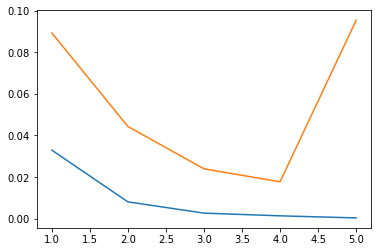

In [36]:
plt.plot(cnn.epo_lis,cnn.loss_lis)
plt.plot(cnn.epo_lis,cnn.val_lis)

In [37]:
y_pred = cnn.predict(X_test)

In [38]:
accuracy_score(y_test,y_pred)

0.9699

#### 【問題7】（アドバンス課題）LeNet
CNNで画像認識を行う際は、フィルタサイズや層の数などを１から考えるのではなく、有名な構造を利用することが一般的です。現在では実用的に使われることはありませんが、歴史的に重要なのは1998年の LeNet です。この構造を再現してMNISTに対して動かし、Accuracyを計算してください。

[Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11):2278–2324, 1998.](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)


※上記論文から引用

サブサンプリングとは現在のプーリングに相当するものです。現代風に以下のように作ってみることにします。活性化関数も当時はシグモイド関数ですが、ReLUとします。

畳み込み層　出力チャンネル数6、フィルタサイズ5×5、ストライド1
ReLU
最大プーリング
畳み込み層　出力チャンネル数16、フィルタサイズ5×5、ストライド1
ReLU
最大プーリング
平滑化
全結合層　出力ノード数120
ReLU
全結合層　出力ノード数84
ReLU
全結合層　出力ノード数10
ソフトマックス関数

In [21]:
class LaNet():
    def __init__(self,lr=0.01,sigma=0.01,n_node1=120,n_node2=84,n_output=10,verbose=True,epoch=5,batch_size=10,activation="tanh",initial="he",optimizer="sgd",f_num=6,f_num2=16,f_h=5,f_w=5,stride=1):
        self.lr = lr
        self.sigma = sigma
        self.n_nodes1 = n_node1
        self.n_nodes2 = n_node2
        self.n_output = n_output
        self.epoch = epoch
        self.verbose = verbose
        self.batch = batch_size
        self.activation = activation
        self.initial = initial
        self.optimizer = optimizer
        self.f_num = f_num
        self.f_num2 = f_num2
        self.f_h = f_h
        self.f_w = f_w
        self.stride = stride

    def fit(self,X,y,X_val=None,y_val=None):
        get_mini_batch = GetMiniBatch(X, y, self.batch)
        #val
        if X_val is not None:      
            test_mini_batch = GetMiniBatch(X_val, y_val) 

        self.B = self.batch
        N,C,I_h,I_w= X.shape
        self.I_shape = X.shape

        if self.optimizer == "sgd":
            optimizer1 = SGD(self.lr)
            optimizer2 = SGD(self.lr)
            optimizer3 = SGD(self.lr)
            optimizer4 = SGD(self.lr)

        if self.activation == "tanh":
            self.activation1 = Tanh()
            self.activation2= Tanh()
            self.activation3 = Tanh()
            self.activation4 = Tanh()
        elif self.activation == "relu":
            self.activation1 = ReLU2()
            self.activation2= ReLU2()
            self.activation3= ReLU2()
            self.activation4= ReLU2()


        if self.initial == "simple":
            initial1 = SimpleInitializer(self.sigma)
            initial2 = SimpleInitializer(self.sigma)    
            initial3 = SimpleInitializer(self.sigma)
            initial4 = SimpleInitializer(self.sigma)    
        elif self.initial == "he":
            initial1 = HeInitializer()
            initial2 = HeInitializer()    
            initial3 = HeInitializer()
            initial4 = HeInitializer()    
        #1
        self.CON2_1 = Conv2d(self.B,self.f_num,self.f_h,self.f_w,initial1,optimizer1,self.stride,self.I_shape,1)
        # con1_out = self.CON2_1.output(I_h,I_w,self.f_h,self.f_w)
        # o_shape1 = self.f_num,*con1_out
        # print("ohsape",o_shape1)
        self.Pool1 = MaxPool2D(self.CON2_1)

        self.CON2_2 = Conv2d(self.B,self.f_num2,self.f_h,self.f_w,initial1,optimizer1,self.stride,self.I_shape,self.f_num)
        #    o_shape2 = self.f_num2,20,20
        self.Pool2 = MaxPool2D(self.CON2_2)

        self.flat = Flatten()
        # O_h,O_w = self.CON2_2.output(20,20,self.f_h,self.f_w)
        out = self.f_num2*18*18
        self.FC1 = FC(out, self.n_nodes1, initial2, optimizer2)
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, initial3, optimizer3)
        self.FC3 = FC(self.n_nodes2, self.n_output, initial4, optimizer4)
        
        self.activation5 = Softmax()

        self.epo_lis = []
        self.loss_lis = []
        self.val_lis = []
        for i in range(self.epoch):
            for mini_X_train, mini_y_train in get_mini_batch:
                Y = (mini_y_train.reshape(-1,1)==np.arange(10)).astype(np.float64)
                self._forward(mini_X_train)

                dA4, loss = self.activation5.backward(Y) 
                #print(loss)# 交差エントロピー誤差とソフトマックスを合わせている
                #print("dA3",dA3.shape)
                dZ4 = self.FC3.backward(dA4)
                #print("dZ4",dZ4.shape )
                dA3 = self.activation4.backward(dZ4)
                #print('dA3',dA3)
                dZ3 = self.FC2.backward(dA3)
                #print('dZ3',dZ3)
                dA2 = self.activation3.backward(dZ3)
                #print('dA2',dA2)
                dZ2 = self.FC1.backward(dA2) 
                #print('dZ2',dZ2)
                dF = self.flat.backward(dZ2)
                #print('dF',dF)
                dP2 = self.Pool2.backward(dF,self.Z1)

                dA1 = self.activation2.backward(dP2)
                # print('dA1',dA1.shape)
                dZ1 = self.CON2_2.backward(dA1,self.P1)
                #print('dZ1',dZ1.shape)
                dP1 = self.Pool1.backward(dZ1,self.Z0)
                dA1 = self.activation1.backward(dP1)
                #print('dA1',dA1)
                # print("dA1")
                dZ0 = self.CON2_1.backward(dA1,mini_X_train)
                # print("dZ0")
            self.loss_lis.append(loss)
            #検証
            # print(i)
            if X_val is not None:
                for mini_X_val,mini_y_val in test_mini_batch:
                    y_val_one = (mini_y_val.reshape(-1,1)==np.arange(10)).astype(np.float64)
                    y_pre = np.argmax(self._forward(mini_X_val)  ,axis=1)
                    accura = accuracy_score(mini_y_val,y_pre)
                self.val_lis.append(self.activation5.backward(y_val_one)[1])
            self.epo_lis.append(i+1)
            #verboseをTrueにした際は学習過程などを出力する
            if self.verbose:
                print( "epoch",i+1,"loss{:.3f}".format(loss),"accuracy:",accura,"ini",self.initial,"activation",self.activation,"optimizer",self.optimizer)
            pass
    def _forward(self,X):
        self.A0 = self.CON2_1.forward(X)
        #print(A0.shape)
        self.Z0 = self.activation1.forward(self.A0)
        #print('Z0',self.Z0.shape)
        self.P1 = self.Pool1.forward(self.Z0)
        # print("P1",self.P1.shape)
        self.A1 = self.CON2_2.forward(self.P1)
        #print("A1shape",self.A1.shape)
        self.Z1 = self.activation2.forward(self.A1)
        # print("Z1",self.Z1.shape)
        self.P2 = self.Pool2.forward(self.Z1)
        # print("pool2",self.P2.shape)
        F = self.flat.forward(self.P2)
        # print('F',F.shape)
        A2 = self.FC1.forward(F)
        #print('A1',A1.shape)
        Z2 = self.activation3.forward(A2)
        #print(Z1.shape)
        A3 = self.FC2.forward(Z2)
        #print('A2',A2.shape)
        Z3 = self.activation4.forward(A3)
        #print('Z2',Z2.shape)
        A4 = self.FC3.forward(Z3)
        #print("A3",A3.shape)
        Z4 = self.activation5.forward(A4)        
        #print('Z3',Z3.shape)
        return Z4
    def predict(self,X):

        return np.argmax(self._forward(X),axis=1)

In [23]:
lanet = LaNet(epoch=5,activation="relu",initial="he",optimizer="sgd")

lanet.fit(X_train,y_train,X_val,y_val)

epoch 1 loss2.301 accuracy: 0.1 ini he activation relu optimizer sgd
epoch 2 loss2.309 accuracy: 0.1 ini he activation relu optimizer sgd
epoch 3 loss2.310 accuracy: 0.1 ini he activation relu optimizer sgd
epoch 4 loss2.310 accuracy: 0.1 ini he activation relu optimizer sgd
epoch 5 loss2.310 accuracy: 0.1 ini he activation relu optimizer sgd


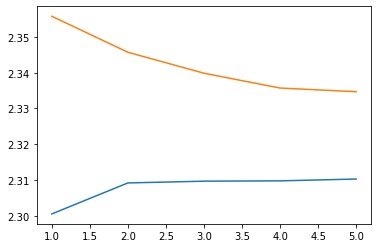

In [25]:
plt.plot(lanet.epo_lis,lanet.loss_lis)
plt.plot(lanet.epo_lis,lanet.val_lis)

In [30]:
y_pred2 = lanet.predict(X_test)
accuracy_score(y_test,y_pred2)

0.0976

#### 【問題8】（アドバンス課題）有名な画像認識モデルの調査
CNNの代表的な構造としてははAlexNet(2012)、VGG16(2014)などがあります。こういったものはフレームワークで既に用意されていることも多いです。

どういったものがあるか簡単に調べてまとめてください。名前だけでも見ておくと良いでしょう。

《参考》

[Applications - Keras Documentation](https://keras.io/ja/applications/)

#### 【問題9】出力サイズとパラメータ数の計算
CNNモデルを構築する際には、全結合層に入力する段階で特徴量がいくつになっているかを事前に計算する必要があります。

また、巨大なモデルを扱うようになると、メモリや計算速度の関係でパラメータ数の計算は必須になってきます。フレームワークでは各層のパラメータ数を表示させることが可能ですが、意味を理解していなくては適切な調整が行えません。

以下の3つの畳み込み層の出力サイズとパラメータ数を計算してください。パラメータ数についてはバイアス項も考えてください。

1.

入力サイズ : 144×144, 3チャンネル
フィルタサイズ : 3×3, 6チャンネル
ストライド : 1
パディング : なし

2.

入力サイズ : 60×60, 24チャンネル
フィルタサイズ : 3×3, 48チャンネル
ストライド　: 1
パディング : なし

3.

入力サイズ : 20×20, 10チャンネル
フィルタサイズ: 3×3, 20チャンネル
ストライド : 2
パディング : なし

＊最後の例は丁度良く畳み込みをすることができない場合です。フレームワークでは余ったピクセルを見ないという処理が行われることがあるので、その場合を考えて計算してください。端が欠けてしまうので、こういった設定は好ましくないという例です。

In [1504]:
def out_calc(H,W,F_h,F_w,P,S,C,F_c):
    O_h = int((H + 2*P - F_h)/ S + 1)
    O_w = int((W + 2*P - F_w)/ S + 1)
    param = F_h * F_w * C* F_c + F_c
    return F_c,O_h,O_w,param

In [1505]:
print("出力サイズ","パラメータ数")
print("#1")
print(out_calc(144,144,3,3,0,1,3,6))
print("#2")
print(out_calc(60,60,3,3,0,1,24,48))
print("#3")
print(out_calc(20,20,3,3,0,2,10,20))


出力サイズ パラメータ数
#1
(6, 142, 142, 168)
#2
(48, 58, 58, 10416)
#3
(20, 9, 9, 1820)


#### 【問題10】（アドバンス課題）フィルタサイズに関する調査
畳み込み層にはフィルタサイズというハイパーパラメータがありますが、2次元畳み込み層において現在では3×3と1×1の使用が大半です。以下のそれぞれを調べたり、自分なりに考えて説明してください。

7×7などの大きめのものではなく、3×3のフィルタが一般的に使われる理由
高さや幅方向を持たない1×1のフィルタの効果